# Prepare Datasets

Once the datasets are obtained, they must be aligned and cropped to the same region. In this notebook, we crop the Planet scene and ground truth data to the aoi.

The sections are:
- Crop Ground Truth Data to AOI
- Crop Image to AOI
- Visualize Ground Truth Data over Image

Note: there are quite a few cells that are dedicated to defining utility functions that have broad applicability and can be lifted from this notebook. They are indicated by a line at the top of the cell that starts with

```
# Utility functions:
```

In [1]:
from collections import namedtuple
import copy
import json
import os
import subprocess
import tempfile

import ipyleaflet as ipyl

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from shapely.geometry import shape, mapping

%matplotlib inline

### Input Data

In [2]:
# These datasets are created in identify-datasets notebook
data_folder = os.path.join('data', 'train')
pl_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS.tif')
assert os.path.isfile(pl_filename)

aoi_filename = os.path.join(data_folder, 'aoi.geojson')
assert os.path.isfile(aoi_filename)

ground_truth_filename = os.path.join(data_folder, 'ground-truth.geojson')
assert os.path.isfile(ground_truth_filename)

### Output Data

In [3]:
def add_suffix(filename, suffix):
    """Adds the suffix to the filename, keeping same extension"""
    prefix, extension = filename.rsplit('.', 1)
    return '{}_{}.{}'.format(prefix, suffix, extension)

cropped_ground_truth_filename = add_suffix(ground_truth_filename, 'cropped')
print(cropped_ground_truth_filename)

cropped_filename = add_suffix(pl_filename, 'cropped')
print(cropped_filename)

data/train/ground-truth_cropped.geojson
data/train/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


## Crop Ground Truth Data to AOI

In [4]:
# Utility functions: cropping polygons

# Uses shapely for geospatial operations
def crop_polygons_to_aoi(polygons, aoi):
    """Crops polygons to the aoi.
    
    Polygons within aoi are copied. For Polygons that intersect aoi boundary, the 
    intersection geometry is saved. If the intersection is a MultiPolygon, it is
    stored as multiple Polygons.
    
    :param dict aoi: geojson polygon describing crop feature
    :param list features: geojson polygons to be cropped
    """
    aoi_shp = shape(aoi['geometry'])
    cropped_features = []
    for f in polygons:
        shp = shape(f['geometry'])
        assert shp.type == 'Polygon'
        
        if shp.within(aoi_shp):
            cropped_features.append(copy.deepcopy(f))
        elif shp.intersects(aoi_shp):
            # 'cut' features at the aoi boundary by the aoi
            cropped_shp = shp.intersection(aoi_shp)
            
            try:
                # try to iterate, which only works for MultiPolygon
                for s in cropped_shp:
                    new_f = copy.deepcopy(f)
                    new_f['geometry'] = mapping(s)
                    cropped_features.append(new_f)
            except TypeError:
                # Polygon is not iterable
                new_f = copy.deepcopy(f)
                new_f['geometry'] = mapping(cropped_shp)
                cropped_features.append(new_f)
    return cropped_features

In [5]:
# Utility functions: loading and saving geojson

def save_geojson(features, filename):
    with open(filename, 'w') as f:
        f.write(json.dumps(features))

def load_geojson(filename):
    with open(filename, 'r') as f:
        return json.load(f)

In [6]:
aoi = load_geojson(aoi_filename)
ground_truth_data = load_geojson(ground_truth_filename)
cropped_ground_truth_data = crop_polygons_to_aoi(ground_truth_data, aoi)
print(len(cropped_ground_truth_data))

223


#### Save cropped ground truth data

In [7]:
save_geojson(cropped_ground_truth_data, cropped_ground_truth_filename)
print(cropped_ground_truth_filename)
print(os.path.isfile(cropped_ground_truth_filename))

data/train/ground-truth_cropped.geojson
True


## Crop Image to AOI

In [8]:
# Utility functions: crop and project an image

def _gdalwarp_crop_options(crop_filename):
    return ['-cutline', crop_filename, '-crop_to_cutline']
    
def _gdalwarp_project_options(src_proj, dst_proj):
    return ['-s_srs', src_proj, '-t_srs', dst_proj]

def _gdalwarp(input_filename, output_filename, options):
    commands = ['gdalwarp'] + options + \
               ['-overwrite',
                input_filename,
                output_filename]
    print(' '.join(commands))
    subprocess.check_call(commands)

# uses Rasterio to get image srs if dst_srs is specified
def warp(input_filename,
         output_filename,
         crop_filename=None,
         dst_srs=None):
    options = []

    if crop_filename is not None:
        options += _gdalwarp_crop_options(crop_filename)

    if dst_srs is not None:
        src_srs = rasterio.open(input_filename).crs['init']
        options += _gdalwarp_project_options(src_srs, dst_srs)
    
    _gdalwarp(input_filename, output_filename, options)

In [9]:
warp(pl_filename, cropped_filename, crop_filename=aoi_filename)
print(cropped_filename)
print(os.path.isfile(cropped_filename))

gdalwarp -cutline data/train/aoi.geojson -crop_to_cutline -overwrite data/train/20160831_180231_0e0e_3B_AnalyticMS.tif data/train/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif
data/train/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif
True


### Visualize Cropped Image

In [10]:
# Utility functions: loading an image

NamedBands = namedtuple('NamedBands', 'b, g, r, nir')

def load_masked_bands(filename):
    """Loads a 4-band BGRNir Planet Image file as a list of masked bands.
    
    The masked bands share the same mask, so editing one band mask will
    edit them all."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
    
    bands = NamedBands(b=b, g=g, r=r, nir=nir)
    return NamedBands(*[np.ma.array(b, mask=mask)
                        for b in bands])

print(load_masked_bands(cropped_filename).b.shape)

(1343, 1762)


In [11]:
# Utility functions: displaying an image

def _linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def _mask_to_alpha(bands):
    band = np.atleast_3d(bands)[...,0]
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def _add_alpha_mask(bands):
    return np.dstack([bands, _mask_to_alpha(bands)])

def bands_to_display(bands, alpha=True):
    """Converts a list of bands to a 3-band rgb, normalized array for display."""
    rgb_bands = np.dstack(bands[:3])

    old_min = np.percentile(rgb_bands, 2)
    old_max = np.percentile(rgb_bands, 98)
    new_min = 0
    new_max = 1
    scaled = _linear_scale(rgb_bands.astype(np.double),
                           old_min, old_max, new_min, new_max)
    bands = np.clip(scaled, new_min, new_max)
    if alpha is True:
        bands = _add_alpha_mask(bands)
    return bands

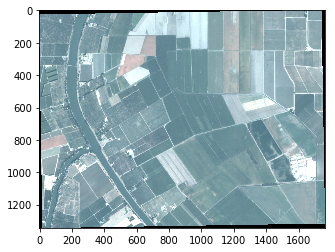

In [12]:
plt.figure()
bands = load_masked_bands(cropped_filename)
plt.imshow(bands_to_display([bands.r, bands.g, bands.b]))

<a id='visualize'></a>

## Visualize Ground Truth Data over Image

To ensure accurate alignment between the planet scene and the ground truth data, we will visualize them overlayed in a geographic reference system.

Define Layer for cropped Planet scene

First we  project the cropped Planet scene to WGS84 for showing on the map. Then we adjust the scene for display and save as an 8-bit jpeg. Finally, we define the image layer using the projected image bounds.

Leaflet appears to support local files if they are jpg ([src](https://gis.stackexchange.com/questions/82936/how-i-can-load-tilelayer-in-leaflet-framework-using-local-tiles))

In [13]:
# Utility functions: creating an image layer for display on a map

def _save_display_image(src_filename, dst_filename):
    # convert to rgb and scale to 8-bit
    bands = load_masked_bands(src_filename)
    img = bands_to_display([bands.r, bands.g, bands.b])

    # save as jpeg
    if(os.path.isfile(dst_filename)): os.remove(dst_filename)
    matplotlib.image.imsave(dst_filename, img)

def create_image_layer(filename):
    with tempfile.NamedTemporaryFile(suffix='.tif') as temp_file:
        projected_filename = temp_file.name

        # project to wgs84
        dst_srs = 'epsg:4326' #WGS84
        warp(filename, projected_filename, dst_srs=dst_srs)
        
        # save as jpeg
        display_image = os.path.join(os.path.dirname(filename), 'display.jpg')
        _save_display_image(projected_filename, display_image)
        
        # determine image layer bounds
        (minx, miny, maxx, maxy) = rasterio.open(projected_filename).bounds
        sw = [miny, minx]
        ne = [maxy, maxx]

        # Create image layer
        return ipyl.ImageOverlay(url=display_image, bounds=[sw, ne])

Define layer for ground truth data

In [14]:
def create_feature_layer(features):
    # Assign colors to classes

    # Class descriptions can be found in datasets-identify notebook
    agg_classes = ['G', 'R', 'F', 'P', 'T', 'D', 'C', 'V']

    # colors determined using [colorbrewer2.org](http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)
    colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']

    class_colors = dict((a,c) for a,c in zip(agg_classes, colors))

    def get_color(cls):
        return class_colors[cls]

    feature_collection = {
        "type": "FeatureCollection",
        "features": features
    }

    for f in feature_collection['features']:
        feature_color = get_color(f['properties']['CLASS1'])
        f['properties']['style'] = {
            'color': feature_color,
            'weight': 1,
            'fillColor': feature_color,
            'fillOpacity': 0.1}

    return ipyl.GeoJSON(data=feature_collection)

In [15]:
zoom = 13
center = [38.30933576918588, -121.55410766601564] # lat/lon
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')

data_map = ipyl.Map(
    center=center, 
    zoom=zoom,
    default_tiles = map_tiles
)

data_map.add_layer(create_image_layer(cropped_filename))
data_map.add_layer(create_feature_layer(cropped_ground_truth_data))

# display
data_map

gdalwarp -s_srs epsg:32610 -t_srs epsg:4326 -overwrite data/train/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif /tmp/tmpoe7x3x6m.tif


Map(center=[38.30933576918588, -121.55410766601564], layers=(TileLayer(options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'), ImageOverlay(bounds=[[38.2909598306474, -121.58530068766386], [38.32800139932046, -121.52415672841586]], options=['attribution', 'opacity'], url='data/train/display.jpg'), GeoJSON(data={'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'id': '2988', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.55595132202392, 38.29170496647727), (-121.55555348576303, 38.29199674024625), (-121.55546232113151, 38.29201707729366), (-121.55510083483001, 38.29170496647727), (-121.55595132202392, 38.29170496647727)),)}, 'properties': {'AREA': 44894.23456, 'PERIMETER': 842.84361, 'BL_X': 626328, 'BL_Y': 4239055, 'ACRES': 11.094, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'D', 'SUBCLASS1': '6', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'P', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S D 6*iP00******************', 'LABEL': 'D6', 'SURVEYAREA': 'SACRAMENTO', 'SURVEYYEAR': '2015', 'style': {'color': '#1d91c0', 'weight': 1, 'fillColor': '#1d91c0', 'fillOpacity': 0.1}}}, {'type': 'Feature', 'id': '2989', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.54524599892193, 38.29170496647727), (-121.54496883899117, 38.291878465307164), (-121.54488631775922, 38.29192036105714), (-121.54483787541562, 38.29192214369899), (-121.54456913621036, 38.29170496647727), (-121.54524599892193, 38.29170496647727)),)}, 'properties': {'AREA': 224051.71615, 'PERIMETER': 3128.82973, 'BL_X': 627575, 'BL_Y': 4238758, 'ACRES': 55.364, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'F', 'SUBCLASS1': '6', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'F', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S F 6*iF00******************', 'LABEL': 'F6', 'SURVEYAREA': 'SACRAMENTO', 'SURVEYYEAR': '2015', 'style': {'color': '#c7e9b4', 'weight': 1, 'fillColor': '#c7e9b4', 'fillOpacity': 0.1}}}, {'type': 'Feature', 'id': '3012', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.56018263827775, 38.29170496647727), (-121.56069435398125, 38.29214818833579), (-121.56031791025025, 38.29237805053205), (-121.5600632180496, 38.29216547767146), (-121.55968507148205, 38.29239310722565), (-121.5588912612093, 38.29170496647727), (-121.56018263827775, 38.29170496647727)),)}, 'properties': {'AREA': 24675.90017, 'PERIMETER': 777.90278, 'BL_X': 626011, 'BL_Y': 4239116, 'ACRES': 6.098, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'D', 'SUBCLASS1': '6', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'P', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S D 6*iP00******************', 'LABEL': 'D6', 'SURVEYAREA': 'SACRAMENTO', 'SURVEYYEAR': '2015', 'style': {'color': '#1d91c0', 'weight': 1, 'fillColor': '#1d91c0', 'fillOpacity': 0.1}}}, {'type': 'Feature', 'id': '3031', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.5539326031044, 38.29170496647727), (-121.55251525219118, 38.292567300506754), (-121.55153397978536, 38.29170496647727), (-121.5539326031044, 38.29170496647727)),)}, 'properties': {'AREA': 86113.45631, 'PERIMETER': 1209.5815, 'BL_X': 626628, 'BL_Y': 4239056, 'ACRES': 21.279, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'D', 'SUBCLASS1': '6', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'P', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', '

Awesome! The data looks nicely registered to the imagery and the crop outlines don't appear to have changed much over the years.

# Test Data

Repeat the above procedures for the test data.

In [16]:
# These datasets are created in identify-datasets notebook
data_folder = os.path.join('data', 'test')
pl_filename = os.path.join(data_folder, '20160831_180257_0e26_3B_AnalyticMS.tif')
assert os.path.isfile(pl_filename)

aoi_filename = os.path.join(data_folder, 'aoi.geojson')
assert os.path.isfile(aoi_filename)

ground_truth_filename = os.path.join(data_folder, 'ground-truth.geojson')
assert os.path.isfile(ground_truth_filename)

# These datasets are created in this notebook
cropped_ground_truth_filename = add_suffix(ground_truth_filename, 'cropped')
print(cropped_ground_truth_filename)

cropped_filename = add_suffix(pl_filename, 'cropped')
print(cropped_filename)

data/test/ground-truth_cropped.geojson
data/test/20160831_180257_0e26_3B_AnalyticMS_cropped.tif


340
gdalwarp -cutline data/test/aoi.geojson -crop_to_cutline -overwrite data/test/20160831_180257_0e26_3B_AnalyticMS.tif data/test/20160831_180257_0e26_3B_AnalyticMS_cropped.tif


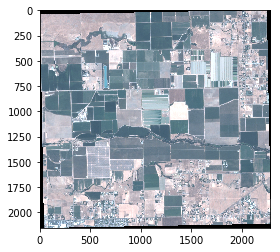

In [17]:
# crop ground truth data
aoi = load_geojson(aoi_filename)
ground_truth_data = load_geojson(ground_truth_filename)
cropped_ground_truth_data = crop_polygons_to_aoi(ground_truth_data, aoi)
print(len(cropped_ground_truth_data))

# save cropped ground truth data
save_geojson(cropped_ground_truth_data, cropped_ground_truth_filename)

# save cropped image
warp(pl_filename, cropped_filename, crop_filename=aoi_filename)

# Visualize cropped image
plt.figure()
bands = load_masked_bands(cropped_filename)
plt.imshow(bands_to_display([bands.r, bands.g, bands.b]))

In [18]:
zoom = 12
center = [38.31660912100042, -121.27017974853516] # lat/lon
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')

data_map = ipyl.Map(
    center=center, 
    zoom=zoom,
    default_tiles = map_tiles
)

data_map.add_layer(create_image_layer(cropped_filename))
data_map.add_layer(create_feature_layer(cropped_ground_truth_data))

# display
data_map

gdalwarp -s_srs epsg:32610 -t_srs epsg:4326 -overwrite data/test/20160831_180257_0e26_3B_AnalyticMS_cropped.tif /tmp/tmpim5y96ob.tif


Map(center=[38.31660912100042, -121.27017974853516], layers=(TileLayer(options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'), ImageOverlay(bounds=[[38.28798796490665, -121.31264881635633], [38.34735796796882, -121.23303481850654]], options=['attribution', 'opacity'], url='data/test/display.jpg'), GeoJSON(data={'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'id': '10906', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.26311573121106, 38.28911976564886), (-121.26309824204209, 38.289263573446426), (-121.26340336500914, 38.28927552343227), (-121.26341580611164, 38.28958419507872), (-121.26335908094813, 38.290060214043095), (-121.2633553819847, 38.29021303818384), (-121.26200888330872, 38.2901989348931), (-121.26202642045222, 38.28924931063856), (-121.26202881277432, 38.28911976564886), (-121.26311573121106, 38.28911976564886)),)}, 'properties': {'AREA': 21779.33318, 'PERIMETER': 662.19543, 'BL_X': 651939, 'BL_Y': 4239347, 'ACRES': 5.382, 'WATERSOURC': '*', 'MULTIUSE': 'S', 'CLASS1': 'G', 'SUBCLASS1': '**', 'SPECOND1': '*', 'IRR_TYP1PA': 'n', 'IRR_TYP1PB': '*', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S G***n*00******************', 'LABEL': 'G', 'SURVEYAREA': 'SACRAMENTO', 'SURVEYYEAR': '2015', 'style': {'color': '#ffffd9', 'weight': 1, 'fillColor': '#ffffd9', 'fillOpacity': 0.1}}}, {'type': 'Feature', 'id': '10912', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.27387084562929, 38.289483478864135), (-121.27380356434945, 38.28945030048625), (-121.27371847837294, 38.28940255516356), (-121.2736526374077, 38.2893085982383), (-121.27364885313192, 38.28911976564886), (-121.27583252426554, 38.28911976564886), (-121.2758015548212, 38.28920072692591), (-121.27566679006253, 38.289334650810105), (-121.27555504453117, 38.28945460723111), (-121.27539483833684, 38.289513051298826), (-121.27475993972087, 38.28949656053128), (-121.27420131009707, 38.28951695343376), (-121.27398357185537, 38.28951374933191), (-121.27387084562929, 38.289483478864135)),)}, 'properties': {'AREA': 85136.70364, 'PERIMETER': 1466.108, 'BL_X': 650974, 'BL_Y': 4239142, 'ACRES': 21.038, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'P', 'SUBCLASS1': '2', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'B', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S P 2*iB00******************', 'LABEL': 'P2', 'SURVEYAREA': 'SACRAMENTO', 'SURVEYYEAR': '2015', 'style': {'color': '#7fcdbb', 'weight': 1, 'fillColor': '#7fcdbb', 'fillOpacity': 0.1}}}, {'type': 'Feature', 'id': '10945', 'geometry': {'type': 'Polygon', 'coordinates': (((-121.2540035617753, 38.28911976564886), (-121.25400150731784, 38.289247508447), (-121.25399775036826, 38.28948113445232), (-121.25395144588406, 38.289519786506936), (-121.2539700951133, 38.28987770698748), (-121.2538641344081, 38.289944082305496), (-121.25205663199688, 38.28992528930166), (-121.2506839352904, 38.28991099803198), (-121.25068182385712, 38.28911976564886), (-121.2540035617753, 38.28911976564886)),)}, 'properties': {'AREA': 170057.50728, 'PERIMETER': 1758.41103, 'BL_X': 652844, 'BL_Y': 4239134, 'ACRES': 42.022, 'WATERSOURC': '4', 'MULTIUSE': 'S', 'CLASS1': 'V', 'SUBCLASS1': '**', 'SPECOND1': '*', 'IRR_TYP1PA': 'i', 'IRR_TYP1PB': 'D', 'PCNT1': '00', 'CLASS2': '**', 'SUBCLASS2': '**', 'SPECOND2': '*', 'IRR_TYP2PA': '*', 'IRR_TYP2PB': '*', 'PCNT2': '**', 'CLASS3': '**', 'SUBCLASS3': '**', 'SPECOND3': '*', 'IRR_TYP3PA': '*', 'IRR_TYP3PB': '*', 'PCNT3': '**', 'UCF_ATT': 'S V***iD00******************', 'LABEL': 'V', 'SURVEYAREA': 'SACRAMENTO